In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

In [0]:
!cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [0]:
!pip install kaggle

In [5]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.16G/2.16G [00:46<00:00, 56.1MB/s]
100% 2.16G/2.16G [00:46<00:00, 49.8MB/s]


In [6]:
!unzip /content/best-artworks-of-all-time.zip

Archive:  /content/best-artworks-of-all-time.zip
  inflating: images.zip              
  inflating: artists.csv             
  inflating: resized.zip             


In [0]:
!unzip resized.zip

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import h5py

In [2]:
tf.__version__

'2.0.0-beta1'

In [0]:
images = os.listdir('resized/')

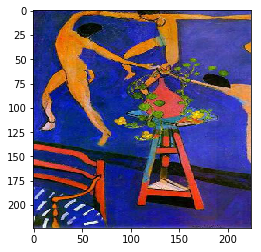

In [5]:
img = tf.keras.preprocessing.image.load_img('/content/resized/'+images[0] , target_size=[224 , 224])
plt.imshow(img)

In [15]:
hdf5_file = h5py.File('/content/dataset.hdf5', mode='w')
hdf5_file.create_dataset("train_img", (len(images), 224 , 224 , 3) , dtype=np.float32)

<HDF5 dataset "train_img": shape (8355, 224, 224, 3), type "<f4">

In [0]:
for i in range(len(images)):
  img_tensor = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img('/content/resized/'+images[i] , target_size=[224 , 224])).reshape([224 , 224 , 3])
  img_tensor /= 255.
  hdf5_file["train_img"][i] = img_tensor

In [0]:
hdf5_file.close()

In [0]:
class generator:
    def __init__(self, file):
        self.file = file

    def __call__(self):
        with h5py.File(self.file, 'r') as hf:
            for im in hf["train_img"]:
                yield im

In [0]:
dataset = tf.data.Dataset.from_generator(generator('/content/dataset.hdf5') , tf.float32).batch(32)

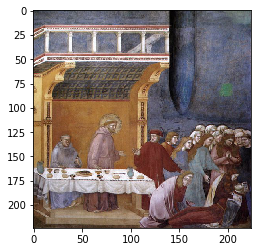

In [26]:
for img in dataset:
  plt.imshow(img[2])
  break

In [0]:
# BUFFER_SIZE = train_data.shape[0]
BATCH_SIZE = 32

In [0]:
def build_generator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7 * 7 * 2048 , use_bias=False , input_shape=(200,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Reshape((7 , 7 , 2048)))
  assert model.output_shape == (None , 7 , 7 , 2048)
  
  model.add(tf.keras.layers.Conv2DTranspose(1024 , (5 , 5) , strides=(1 , 1) , padding='same' , use_bias=False))
  assert model.output_shape == (None , 7 , 7 , 1024)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2DTranspose(512 , (5 , 5) , strides=(2 , 2) , padding='same' , use_bias=False))
  assert model.output_shape == (None , 14 , 14 , 512)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2DTranspose(256 , (5 , 5) , strides=(2 , 2) , padding='same' , use_bias=False))
  assert model.output_shape == (None , 28 , 28 , 256)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2DTranspose(128 , (5 , 5) , strides=(2 , 2) , padding='same' , use_bias=False))
  assert model.output_shape == (None , 56 , 56 , 128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2DTranspose(64 , (5 , 5) , strides=(2 , 2) , padding='same' , use_bias=False))
  assert model.output_shape == (None , 112 , 112 , 64)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2DTranspose(3 , (5 , 5) , strides=(2 , 2) , padding='same' , use_bias=False , activation='tanh'))
  assert model.output_shape == (None , 224 , 224 , 3)
  
  return model

In [0]:
generator = build_generator()
noise = tf.random.normal([1 , 200])
gen_img = generator(noise , training=False)

plt.imshow(gen_img[0, :, :, 0])

In [0]:
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32 , (5 , 5) , strides=(2 , 2) , padding='same' , input_shape=[224 , 224 , 3]))
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2D(64 , (5 , 5) , strides=(2 , 2) , padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  
  model.add(tf.keras.layers.Conv2D(128 , (5 , 5) , strides=(2 , 2) , padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  
  model.add(tf.keras.layers.Conv2D(256 , (5 , 5) , strides=(2 , 2) , padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))
  
  return model
  

In [0]:
discriminator = build_discriminator()
pred = discriminator(gen_img)
pred

In [0]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output , fake_output):
  real_loss = loss(tf.ones_like(real_output) , real_output)
  fake_loss = loss(tf.zeros_like(fake_output) , fake_output)
  return real_loss + fake_loss

In [0]:
def generator_loss(fake_output):
  return loss(tf.ones_like(fake_output) , fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
checkpoint_dir = '/content/gdrive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint , checkpoint_dir , max_to_keep = 5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [0]:
EPOCHS = 100
noise_dim = 200

In [0]:
@tf.function
def train_step(images , noise):
  
  with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
    generated_images = generator(noise , training=True)
    real_output = discriminator(images , training=True)
    fake_output = discriminator(generated_images , training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output , fake_output)
    
  grad_generator = gen_tape.gradient(gen_loss , generator.trainable_variables)
  grad_discriminator = disc_tape.gradient(disc_loss , discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_generator , generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(grad_discriminator , discriminator.trainable_variables))

In [0]:
def train(dataset , epochs , start_epoch):
  for epoch in range(start_epoch , epochs):
    start = time.time()
    
    for images in dataset:
      noise = tf.random.normal([BATCH_SIZE , noise_dim])
      train_step(images , noise)
      
    if epoch % 5 == 0:
      ckpt_manager.save()
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [46]:
%%time
train(dataset , EPOCHS , start_epoch)

Time for epoch 1 is 138.88198590278625 sec
Time for epoch 2 is 131.78615713119507 sec
Time for epoch 3 is 134.4707624912262 sec
Time for epoch 4 is 135.79330682754517 sec
Time for epoch 5 is 135.75361323356628 sec
Time for epoch 6 is 146.06533312797546 sec


KeyboardInterrupt: ignored

W0619 19:21:27.721872 140377448015744 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


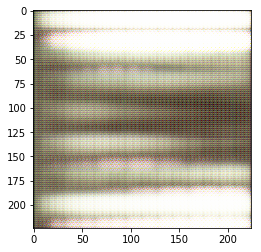

In [49]:
noise = tf.random.normal([1 , 200])
gen_img = generator(noise , training=False)

plt.imshow(tf.squeeze(gen_img))

In [48]:
gen_img.shape

TensorShape([1, 224, 224, 3])